# 📔 About this notebook

PetFinder.my - Pawpularity Contest



## 📝 Memo

- ensemble
    - seed
    - fold
    - size
    - base, large
    - other models
        - CSWin
        - EffNet
        - NFNet
        - [CaiT](https://github.com/facebookresearch/deit/blob/main/README_cait.md)
        - [ConvMixer](https://github.com/tmp-iclr/convmixer)
        - +SVR with feats
        - hybrid swin

# 📚 Library

In [1]:
# General libraries
import collections
import gc
import glob
import json
import math
import os
import pickle
import random
import re
import statistics
import sys
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2
from nfnets.agc import AGC

In [3]:
# Additional local libraries

# https://github.com/microsoft/CSWin-Transformer
sys.path.append("../input/CSWin-Transformer")
import models

# https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
sys.path.append("../input/Yet-Another-EfficientDet-Pytorch")
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import (
    STANDARD_COLORS,
    get_index_label,
    invert_affine,
    plot_one_box,
    postprocess,
    preprocess,
    standard_to_bgr,
)

In [4]:
warnings.filterwarnings("ignore")

In [5]:
os.environ["WANDB_CACHE_DIR"] = "/data/home/sugiyama/.cache/wandb"

# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# 再現性がなくなったときは False にする
torch.backends.cudnn.benchmark = True

# Load Data

In [8]:
DATA_DIR = "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [9]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🛠 Config

In [10]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [11]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder2"
    print_freq = 100

    preprocess = False  # crop images
    train = True
    train2 = False  # SVR
    train3 = False  # 100 or not
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

Model examples

- resnet200d
- resnext50_32x4d
- ★dm_nfnet_f3
- vit_base_patch16_384
- tf_efficientnet_b7_ns
- tf_efficientnetv2_l_in21k
- swin_base_patch4_window12_384_in22k
- swin_large_patch4_window7_224_in22k
- ★swin_large_patch4_window12_384_in22k
- CSWin_144_24322_large_224
- CSWin_144_24322_large_384
- convmixer_1536_20

In [12]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 10,
    "epochs": 10,
    "es_patience": 0,
    "batch_size": 16,
    "gradient_accumulation_steps": 8,
    "max_grad_norm": 1000,
    # "agc_clipping": 1e-3,
    "criterion": "BCEWithLogitsLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 5e-6,
    "min_lr": 5e-6,
    "weight_decay": 1e-7,
    # "momentum": 0.9,
    "model_name": "dm_nfnet_f2",
    "model_embedder": "",
    "size": 352,
    # "compound_coef": 6,
    "models": [
        # "swin_large_patch4_window12_384_in22k:v14",
        # "swin_base_patch4_window12_384_in22k:v1",
    ],
    "runs": [
        # "ymawjqn2",  # 71 - swin large 384
        # "tppuuj4q",  # 72 - swin large 224
        # "3ptw9dio",  # 73 - swin base 384
        # "bulu150s",  # 74 - swin base 224
        # "lxvhq95s",  # 99 - nfnet f3 416
    ],
}

In [13]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [14]:
if Config.train:
    wandb_job_type = "training"

elif Config.train2:
    wandb_job_type = "training2"

elif Config.train3:
    wandb_job_type = "training3"

elif Config.preprocess:
    wandb_job_type = "preprocess"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [15]:
wandb_tags.append("basic aug")
# wandb_tags.append("heavy aug")
# wandb_tags.append("mixup")
# wandb_tags.append("cutmix")
# wandb_tags.append("freeze norm")  # for only efficientnet
# wandb_tags.append("crop image")
# wandb_tags.append("tune lr")  # Run only single fold
# wandb_tags.append("agc")  # Adaptive Gradient Clipping for only nfnet

In [16]:
os.environ["WANDB_NOTEBOOK_NAME"] = "petfinder2.ipynb"

In [17]:
if Config.debug or Config.preprocess:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [18]:
config = wandb.config

# EDA 1

In [19]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:xlabel='Pawpularity'>

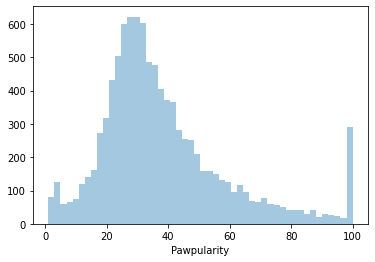

In [20]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

In [21]:
def train_preprocess3(df):
    df["Pawpularity"] = np.where(df["Pawpularity"] == 100, 1, 0)

    return df

In [22]:
if Config.train3:
    train = train_preprocess3(train)
    print(train["Pawpularity"].value_counts())

# EDA 2

# 👑 Load Artifacts

In [23]:
if Config.train2:
    api = wandb.Api()
    for artifact_id in config.models:
        name_version = artifact_id.replace(":", "-")
        if not os.path.exists(name_version):
            os.makedirs(name_version)

        try:
            artifact_path = f"{Config.wandb_entity}/{Config.wandb_project}/{artifact_id}"
            artifact = api.artifact(artifact_path)
            artifact.download(name_version)
        except Exception as e:
            print(f"Error: {artifact_path}, {e}")

In [24]:
if Config.validate:
    api = wandb.Api()

    for n, run_id in enumerate(config.runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            run.file("oof_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["Id", "preds"]]
        oof.columns = ["Id", f"preds{n}"]
        train = pd.merge(train, oof, on="Id")

    print(train.columns)

In [25]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [26]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [27]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:, "bins"] = pd.cut(train["Pawpularity"], bins=num_bins, labels=False)

In [28]:
Fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "bins"]).size())

fold  bins
0     0        33
      1        42
      2       111
      3       203
      4       188
             ... 
9     9        28
      10       20
      11       14
      12       11
      13       36
Length: 140, dtype: int64


# Dataset

In [29]:
if "crop image" in wandb_tags:
    TRAIN_IMAGE_PATH = DATA_DIR + "crop/"
    print("Use croped images.")

In [30]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.features = df.drop(["Id", "Pawpularity", "fold", "bins"], axis=1).values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values / 100.0
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature = torch.tensor(self.features[idx])
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, feature, label
        return image, feature

In [31]:
if Config.debug:
    train_ds = BaseDataset(train)
    image, feature, label = train_ds[0]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

In [32]:
class DetectionDataset(Dataset):
    def __init__(self, df, force_input_size=None):
        self.df = df
        self.files = (f"{TRAIN_IMAGE_PATH}/" + df["Id"] + ".jpg").values

        input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
        self.input_size = input_sizes[config.compound_coef] if force_input_size is None else force_input_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        ori_img, framed_img, framed_meta = preprocess(self.files[idx], max_size=self.input_size)

        x = torch.from_numpy(framed_img[0]).permute(2, 0, 1)

        return x, ori_img, framed_img, framed_meta

In [33]:
if Config.debug and Config.preprocess:
    train_ds = DetectionDataset(train)
    x, ori_img, framed_img, framed_meta = train_ds[0]
    plt.imshow(framed_img[0])
    plt.show()

# Transform

In [34]:
def get_transforms(*, data):
    if data == "train":
        if "basic aug" in wandb_tags:
            return A.Compose(
                [
                    A.Resize(config.size, config.size),
                    # A.RandomResizedCrop(config.size, config.size),
                    # A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    # A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.5),
                    A.Cutout(max_h_size=int(config.size * 0.4), max_w_size=int(config.size * 0.4), num_holes=1, p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

        if "heavy aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.5),
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                    # A.CoarseDropout(p=0.5),
                    # A.Cutout(max_h_size=int(config.size * 0.4), max_w_size=int(config.size * 0.4), num_holes=1, p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

    return A.Compose(
        [
            A.Resize(config.size, config.size),
            # A.CenterCrop(config.size, config.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ]
    )

In [35]:
if Config.debug:
    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    image, feature, label = train_ds[0]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

## CutMix

In [36]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(x, feats, y, alpha=1.0, use_cuda=True):
    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    return mixed_x, mixed_feats, y_a, y_b, lam

In [37]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = cutmix(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

## MixUp

In [38]:
# https://github.com/yuhao318/mwh/blob/main/utils.py
def mixup(x, feats, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    # return mixed_image, mixed_label, lam
    return mixed_x, mixed_feats, y_a, y_b, lam

In [39]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = mixup(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

# Model

In [40]:
# https://github.com/tmp-iclr/convmixer
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[
            nn.Sequential(
                Residual(
                    nn.Sequential(
                        nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"), nn.GELU(), nn.BatchNorm2d(dim)
                    )
                ),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim),
            )
            for i in range(depth)
        ],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )


_cfg = {
    "url": "",
    "num_classes": 1000,
    "input_size": (3, 224, 224),
    "pool_size": None,
    "crop_pct": 0.96,
    "interpolation": "bicubic",
    "mean": timm.data.IMAGENET_DEFAULT_MEAN,
    "std": timm.data.IMAGENET_DEFAULT_STD,
    "classifier": "head",
}


@timm.models.registry.register_model
def convmixer_1536_20(pretrained=False, **kwargs):
    model = ConvMixer(1536, 20, kernel_size=9, patch_size=7, n_classes=1000)
    model.default_cfg = _cfg
    if pretrained:
        path = "../input/pretrained-weights/convmixer_1536_20_ks9_p7.pth.zip"
        timm.models.load_checkpoint(model, path, False)
    return model


@timm.models.registry.register_model
def convmixer_768_32(pretrained=False, **kwargs):
    model = ConvMixer(768, 32, kernel_size=7, patch_size=7, n_classes=1000)
    model.default_cfg = _cfg
    return model

## Base model

In [41]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=config.n_class)

        if "convmixer" in config.model_name:
            self.head = nn.Linear(1000, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        if "convmixer" in config.model_name:
            x = self.head(x)
        return x

In [42]:
def train_mode(model):
    model.train()

    # Freeze batch norm for efficientnet
    if "efficientnet" in config.model_name:
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if isinstance(child2, nn.BatchNorm2d):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

In [43]:
if Config.debug and config.model_name != "" and config.model_embedder == "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

In [44]:
if Config.debug and config.model_name != "" and config.model_embedder == "":
    model = BaseModel(config.model_name)
    model.apply(train_mode)

    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

## Backbone model

In [45]:
class BackboneModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        x = torch.cat([x, feats], dim=1)
        return x

In [46]:
if Config.train2 and Config.debug and config.model_name != "":
    model = BackboneModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

## Hybrid swin transformer

In [47]:
class HybridEmbed(nn.Module):
    """CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """

    def __init__(self, backbone, img_size=224, patch_size=1, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # NOTE Most reliable way of determining output dims is to run forward pass
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))
                if isinstance(o, (list, tuple)):
                    o = o[-1]  # last feature if backbone outputs list/tuple of features
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            if hasattr(self.backbone, "feature_info"):
                feature_dim = self.backbone.feature_info.channels()[-1]
            else:
                feature_dim = self.backbone.num_features
        assert feature_size[0] % patch_size[0] == 0 and feature_size[1] % patch_size[1] == 0
        self.grid_size = (feature_size[0] // patch_size[0], feature_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(feature_dim, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.backbone(x)
        if isinstance(x, (list, tuple)):
            x = x[-1]  # last feature if backbone outputs list/tuple of features
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [48]:
class HybridSwinModel(nn.Module):
    def __init__(self, backbone, embedder, pretrained=True):
        super().__init__()
        self.embedder = timm.create_model(embedder, features_only=True, out_indices=[2], pretrained=pretrained)
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=config.n_class)
        self.backbone.patch_embed = HybridEmbed(self.embedder, img_size=config.size, embed_dim=128)

    @amp.autocast(enabled=Config.amp)
    def forward(self, images, _):
        output = self.backbone(images)
        return output

In [49]:
if Config.debug and config.model_name != "" and config.model_embedder != "":
    model = HybridSwinModel(config.model_name, config.model_embedder)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

# Optimizer

In [50]:
# https://github.com/davda54/sam/blob/main/sam.py
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    # @torch.no_grad()
    @torch.inference_mode()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad:
            self.zero_grad(set_to_none=True)

    # @torch.no_grad()
    @torch.inference_mode()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad:
            self.zero_grad(set_to_none=True)

    # @torch.no_grad()
    @torch.inference_mode()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][
            0
        ].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
            torch.stack(
                [
                    ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                    for group in self.param_groups
                    for p in group["params"]
                    if p.grad is not None
                ]
            ),
            p=2,
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

# Loss

In [51]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [52]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [53]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [54]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

## Early stopping

In [55]:
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_preds = None

    def __call__(self, val_loss, score, model, preds):

        if self.best_score is None:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
        elif val_loss >= self.val_loss_min + self.delta:
            if self.patience <= 0:
                return
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Grad norm

In [56]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1.0 / norm_type)
    return total_norm

## Preprocess

In [57]:
def preprocess_fn(data_loader, model, device):
    pass

## Training

In [58]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    if "freeze norm" in wandb_tags:
        model.apply(train_mode)
    else:
        model.train()
    start = time.time()
    optimizer.zero_grad(set_to_none=True)

    for step, (images, features, labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if epoch < 2 or epoch >= config.epochs - 2:
            mix_decision = 1.0
        else:
            mix_decision = np.random.rand()

        if epoch >= config.epochs - 5:
            mix_decision *= 2

        if "mixup" in wandb_tags and mix_decision < 0.5:
            images, features, label_a, label_b, lam = mixup(images, features, labels, alpha=0.5)

        with amp.autocast(enabled=Config.amp):
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

            if "mixup" in wandb_tags and mix_decision < 0.5:
                loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
            else:
                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps

            if "SAM" in config.optimizer:

                def closure():
                    # y_preds = model(images, features)
                    y_preds = model(images, features).squeeze(1)

                    if "mixup" in wandb_tags and mix_decision < 0.5:
                        loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
                    else:
                        loss = criterion(y_preds, labels)

                    loss.backward()
                    return loss

        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

            if "SAM" in config.optimizer:
                scaler.step(optimizer, closure)
            else:
                scaler.step(optimizer)

            scaler.update()

            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.2e}  "
            )

    return losses.avg

## Validation

In [59]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(valid_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # with torch.no_grad():
        with torch.inference_mode():
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

## Training2 (Inference by backbone)

In [60]:
def train2_inference_fn(data_loader, model, device):
    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(data_loader):
        images = images.to(device)
        features = features.to(device)

        # with torch.no_grad():
        with torch.inference_mode():
            y_preds = model(images, features)
            # y_preds = model(images, features).squeeze(1)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(data_loader) - 1):
            print(
                f"EVAL: [{step}/{len(data_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(data_loader)):s} "
            )

    predictions = np.concatenate(preds)
    return predictions

## Postprocess

# Main loop

## Preprocess Loop

In [61]:
def save_image(preds, imgs, files, imshow=False, imwrite=True):
    for i in range(len(imgs)):
        # if len(preds[i]['rois']) == 0:
        #     continue

        imgs[i] = imgs[i].copy()

        for j in range(len(preds[i]["rois"])):
            # cat or dog
            if preds[i]["class_ids"][j] not in (16, 17):
                continue

            x1, y1, x2, y2 = preds[i]["rois"][j].astype(np.int)
            # obj = obj_list[preds[i]["class_ids"][j]]
            # score = float(preds[i]["scores"][j])
            # plot_one_box(
            #     imgs[i], [x1, y1, x2, y2], label=obj, score=score, color=color_list[get_index_label(obj, obj_list)]
            # )

            # Crop image
            imgs[i] = imgs[i][y1:y2, x1:x2, :]

            # Apply only highest preds
            break

        if imshow:
            cv2.imshow("img", imgs[i])
            cv2.waitKey(0)

        if imwrite:
            cv2.imwrite(f"{DATA_DIR}/crop/{os.path.basename(files[i])}", imgs[i])

In [62]:
def preprocess_loop(df):
    crop_output_dir = f"{DATA_DIR}/crop/"
    # !rm -rf {crop_output_dir}
    os.makedirs(crop_output_dir, exist_ok=True)

    # replace this part with your project's anchor config
    anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
    anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

    threshold = 0.2
    iou_threshold = 0.2

    color_list = standard_to_bgr(STANDARD_COLORS)
    # tf bilinear interpolation is different from any other's, just make do
    force_input_size = None  # set None to use default size
    input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
    input_size = input_sizes[config.compound_coef] if force_input_size is None else force_input_size

    model = EfficientDetBackbone(
        compound_coef=config.compound_coef, num_classes=90, ratios=anchor_ratios, scales=anchor_scales
    )
    model.load_state_dict(
        torch.load(f"../input/pretrained-weights/efficientdet-d{config.compound_coef}.pth", map_location="cpu")
    )

    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    model.requires_grad_(False)
    model.eval()

    files = (f"{TRAIN_IMAGE_PATH}/" + df["Id"] + ".jpg").values

    for file_ in tqdm(files, total=len(files)):
        ori_imgs, framed_imgs, framed_metas = preprocess(file_, max_size=input_size)
        x = torch.stack([torch.from_numpy(fi).to(device) for fi in framed_imgs], 0).permute(0, 3, 1, 2)

        # with torch.no_grad():
        with torch.inference_mode():
            _, regression, classification, anchors = model(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x, anchors, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold)

        out = invert_affine(framed_metas, out)
        save_image(out, ori_imgs, [file_])

## Train loop

In [63]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_ = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_ = DataLoader(
        train_dataset_,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "SAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
            )
        elif config.optimizer == "ASAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
                rho=2.0,
                adaptive=True,
            )

        if "agc" in wandb_tags and "nfnet" in config.model_name:
            if Config.multi_gpu:
                ignore_agc = ["module.model.head.fc"]
            else:
                ignore_agc = ["model.head.fc"]

            optimizer = AGC(
                model.parameters(),
                optimizer,
                clipping=config.agc_clipping,
                model=model,
                ignore_agc=ignore_agc,
            )

        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_dataset):
        num_data = len(train_dataset)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=num_steps,
                max_lr=config.lr,
                min_lr=config.min_lr,
                warmup_steps=(num_steps // 10),
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    if config.model_embedder == "":
        model = BaseModel(config.model_name)
    else:
        model = HybridSwinModel(config.model_name, config.model_embedder)

    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_dataset)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Early stopping
    # ====================================================
    es = EarlyStopping(
        patience=config.es_patience,
        verbose=True,
        path=MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth",
    )

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        if epoch < 2 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_, model, criterion, optimizer, scheduler, scaler, epoch, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        preds *= 100.0

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/valid_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        es(avg_val_loss, score, model, preds)

        if es.early_stop:
            print("Early stopping")
            break

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    valid_folds["preds"] = es.best_preds

    return valid_folds, es.best_score, es.val_loss_min

## Train2 loop

In [64]:
def train2_loop(df, artifact_id, fold):
    LOGGER.info(f"========== ID: {artifact_id} fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    valid_labels = valid_folds["Pawpularity"].values

    # ====================================================
    # Model
    # ====================================================
    model_name = artifact_id.split(":")[0]
    model = BackboneModel(model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    path = f"{artifact_id.replace(':', '-')}/{model_name}_fold{fold}_best.pth"
    model.load_state_dict(torch.load(path))

    # ====================================================
    # Inference by backbone
    # ====================================================

    train_preds = train2_inference_fn(train_loader, model, device)
    valid_preds = train2_inference_fn(valid_loader, model, device)

    scaler = StandardScaler()
    # scaler.fit(np.vstack([train_preds, valid_preds]))

    train_norm = scaler.fit_transform(train_preds)
    valid_norm = scaler.transform(valid_preds)

    scaler_path = MODEL_DIR + f"{model_name}-StandardScaler_fold{fold}_best.pkl"
    pickle.dump(scaler, open(scaler_path, "wb"))

    # ====================================================
    # Tuning SVR parameters
    # ====================================================
    # https://github.com/hkaneko1985/fastoptsvrhyperparams/blob/master/fastoptsvrhyperparams.ipynb
    start_time = time.time()

    svr_epss = 2 ** np.arange(-10, 1, dtype=float)  # Candidates of epsilon
    svr_cs = 2 ** np.arange(-5, 11, dtype=float)  # Candidates of C
    svr_gammas = 2 ** np.arange(-20, 11, dtype=float)  # Candidates of gamma

    # Optimize epsilon with cross-validation
    model_tune_eps = GridSearchCV(SVR(kernel="rbf", C=3), {"epsilon": svr_epss}, verbose=1)
    model_tune_eps.fit(train_norm, train_dataset.labels)
    optimal_eps = model_tune_eps.best_params_["epsilon"]
    elapsed = time.time() - start_time
    print(f"Optimized eps: {elapsed:.0f}s")

    # Optimize C with cross-validation
    model_tune_c = GridSearchCV(SVR(kernel="rbf", epsilon=optimal_eps), {"C": svr_cs}, verbose=1)
    model_tune_c.fit(train_norm, train_dataset.labels)
    optimal_c = model_tune_c.best_params_["C"]
    elapsed = time.time() - start_time
    print(f"Optimized c: {elapsed:.0f}s")

    # Optimize gamma with cross-validation (optional)
    model_tune_gamma = GridSearchCV(
        SVR(kernel="rbf", epsilon=optimal_eps, C=optimal_c), {"gamma": svr_gammas}, verbose=1
    )
    model_tune_gamma.fit(train_norm, train_dataset.labels)
    optimal_gamma = model_tune_gamma.best_params_["gamma"]
    elapsed = time.time() - start_time
    print(f"Optimized gamma: {elapsed:.0f}s")

    best_params = {
        "C": optimal_c,
        "epsilon": optimal_eps,
        "gamma": optimal_gamma,
    }
    print(f"{best_params}")

    param_path = MODEL_DIR + f"{model_name}-SVR-params_fold{fold}_best.json"
    with open(param_path, "w") as f:
        json.dump(best_params, f, indent=4)

    # ====================================================
    # Training SVR
    # ====================================================
    start_time = time.time()

    model_svr = SVR(C=optimal_c, epsilon=optimal_eps, gamma=optimal_gamma)
    model_svr.fit(train_norm, train_dataset.labels)

    preds = model_svr.predict(valid_norm)
    preds *= 100.0

    # scoring
    # score = get_score(valid_labels, preds.argmax(1))
    score = get_score(valid_labels, preds)

    elapsed = time.time() - start_time
    LOGGER.info(f"Score: {score}  time: {elapsed:.0f}s")

    svr_path = MODEL_DIR + f"{model_name}-SVR_fold{fold}_best.pkl"
    pickle.dump(model_svr, open(svr_path, "wb"))

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    # valid_folds["preds"] = es.best_preds
    valid_folds["preds"] = preds

    return valid_folds, score

# Main function

In [65]:
def main():
    # ====================================================
    # Preprocess
    # ====================================================
    if Config.preprocess:
        preprocess_loop(train)

    # ====================================================
    # Training
    # ====================================================
    if Config.train or Config.train3:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)

            if "tune lr" in wandb_tags:
                break

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns=["fold", "score", "loss"])
        run.log({"Fold Result": table})

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

    # ====================================================
    # Validation
    # ====================================================
    if Config.validate:
        cols = [f"preds{n}" for n in range(len(config.runs))]
        train["preds"] = train[cols].values.mean(axis=1)

        LOGGER.info(f"========== CV ==========")
        get_result(train)

        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    # ====================================================
    # Training SVR
    # ====================================================
    if Config.train2:
        oof_df = pd.DataFrame()
        oof_result = []
        for n, artifact_id in enumerate(config.models):

            for fold in range(config.n_fold):
                seed_torch(seed + fold)
                _oof_df, score = train2_loop(train, artifact_id, fold)
                oof_df = pd.concat([oof_df, _oof_df])

                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df, fold)

            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)

            break

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(f"{artifact_id.split(':')[0]}-SVR", type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

# 🚀 Run

In [ ]:
main()

========== fold: 0 training ==========


Epoch: [1][0/557] Elapsed 0m 18s (remain 175m 45s) Loss: 0.6870 Grad: 8177.9212 LR: 5.00e-06  
Epoch: [1][100/557] Elapsed 1m 1s (remain 4m 35s) Loss: 0.6665 Grad: 18530.5879 LR: 5.00e-06  
Epoch: [1][200/557] Elapsed 1m 43s (remain 3m 2s) Loss: 0.6605 Grad: 10964.2776 LR: 5.00e-06  
Epoch: [1][300/557] Elapsed 2m 24s (remain 2m 3s) Loss: 0.6580 Grad: 27310.8594 LR: 5.00e-06  
Epoch: [1][400/557] Elapsed 3m 6s (remain 1m 12s) Loss: 0.6565 Grad: 7894.9321 LR: 5.00e-06  
Epoch: [1][500/557] Elapsed 3m 48s (remain 0m 25s) Loss: 0.6547 Grad: 16216.5100 LR: 5.00e-06  
Epoch: [1][556/557] Elapsed 4m 11s (remain 0m 0s) Loss: 0.6538 Grad: 18460.4398 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 4s) Loss: 0.6594 


Epoch 1 - avg_train_loss: 0.6538  avg_val_loss: 0.6451  time: 265s
Epoch 1 - Score: 18.101897448851595


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6451 
Validation loss decreased (inf --> 0.645088).  Saving model ...
Epoch: [2][0/557] Elapsed 0m 1s (remain 11m 37s) Loss: 0.6351 Grad: 9675.8132 LR: 5.00e-06  
Epoch: [2][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6405 Grad: 16423.1784 LR: 5.00e-06  
Epoch: [2][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6397 Grad: 6562.3151 LR: 5.00e-06  
Epoch: [2][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6394 Grad: 24839.6127 LR: 5.00e-06  
Epoch: [2][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.6381 Grad: 10361.1747 LR: 5.00e-06  
Epoch: [2][500/557] Elapsed 3m 30s (remain 0m 23s) Loss: 0.6381 Grad: 32565.7628 LR: 5.00e-06  
Epoch: [2][556/557] Elapsed 3m 53s (remain 0m 0s) Loss: 0.6381 Grad: 14954.2254 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 5s) Loss: 0.6536 


Epoch 2 - avg_train_loss: 0.6381  avg_val_loss: 0.6426  time: 247s
Epoch 2 - Score: 17.77218696443636


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6426 
Validation loss decreased (0.645088 --> 0.642640).  Saving model ...
Epoch: [3][0/557] Elapsed 0m 1s (remain 14m 12s) Loss: 0.6253 Grad: 25950.9462 LR: 5.00e-06  
Epoch: [3][100/557] Elapsed 0m 43s (remain 3m 15s) Loss: 0.6369 Grad: 26076.4057 LR: 5.00e-06  
Epoch: [3][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6347 Grad: 9609.2132 LR: 5.00e-06  
Epoch: [3][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6337 Grad: 39802.6951 LR: 5.00e-06  
Epoch: [3][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.6332 Grad: 7698.0863 LR: 5.00e-06  
Epoch: [3][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.6331 Grad: 20888.1229 LR: 5.00e-06  
Epoch: [3][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.6331 Grad: 50723.7619 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 8s) Loss: 0.6495 


Epoch 3 - avg_train_loss: 0.6331  avg_val_loss: 0.6418  time: 248s
Epoch 3 - Score: 17.635714815316064


EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6418 
Validation loss decreased (0.642640 --> 0.641799).  Saving model ...
Epoch: [4][0/557] Elapsed 0m 1s (remain 11m 40s) Loss: 0.6022 Grad: 5544.0854 LR: 5.00e-06  
Epoch: [4][100/557] Elapsed 0m 42s (remain 3m 12s) Loss: 0.6285 Grad: 26884.7434 LR: 5.00e-06  
Epoch: [4][200/557] Elapsed 1m 23s (remain 2m 28s) Loss: 0.6273 Grad: 10845.9938 LR: 5.00e-06  
Epoch: [4][300/557] Elapsed 2m 4s (remain 1m 46s) Loss: 0.6277 Grad: 33176.7328 LR: 5.00e-06  
Epoch: [4][400/557] Elapsed 2m 45s (remain 1m 4s) Loss: 0.6271 Grad: 22791.5619 LR: 5.00e-06  
Epoch: [4][500/557] Elapsed 3m 26s (remain 0m 23s) Loss: 0.6265 Grad: 58692.4474 LR: 5.00e-06  
Epoch: [4][556/557] Elapsed 3m 49s (remain 0m 0s) Loss: 0.6269 Grad: 38959.3260 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 12s) Loss: 0.6449 


Epoch 4 - avg_train_loss: 0.6269  avg_val_loss: 0.6442  time: 243s
Epoch 4 - Score: 17.918583918118053


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6442 
Epoch: [5][0/557] Elapsed 0m 1s (remain 13m 40s) Loss: 0.6500 Grad: 13947.2866 LR: 5.00e-06  
Epoch: [5][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6239 Grad: 37259.2899 LR: 5.00e-06  
Epoch: [5][200/557] Elapsed 1m 26s (remain 2m 32s) Loss: 0.6222 Grad: 41193.3517 LR: 5.00e-06  
Epoch: [5][300/557] Elapsed 2m 8s (remain 1m 49s) Loss: 0.6204 Grad: 41506.6631 LR: 5.00e-06  
Epoch: [5][400/557] Elapsed 2m 50s (remain 1m 6s) Loss: 0.6199 Grad: 17049.1306 LR: 5.00e-06  
Epoch: [5][500/557] Elapsed 3m 32s (remain 0m 23s) Loss: 0.6203 Grad: 31068.5385 LR: 5.00e-06  
Epoch: [5][556/557] Elapsed 3m 55s (remain 0m 0s) Loss: 0.6202 Grad: 42413.6613 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 4s) Loss: 0.6415 


Epoch 5 - avg_train_loss: 0.6202  avg_val_loss: 0.6484  time: 249s
Epoch 5 - Score: 18.398459726966426


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6484 
Epoch: [6][0/557] Elapsed 0m 1s (remain 13m 6s) Loss: 0.6448 Grad: 12743.6789 LR: 5.00e-06  
Epoch: [6][100/557] Elapsed 0m 43s (remain 3m 17s) Loss: 0.6138 Grad: 39772.2312 LR: 5.00e-06  
Epoch: [6][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6138 Grad: 34867.4805 LR: 5.00e-06  
Epoch: [6][300/557] Elapsed 2m 8s (remain 1m 48s) Loss: 0.6119 Grad: 51887.2054 LR: 5.00e-06  
Epoch: [6][400/557] Elapsed 2m 50s (remain 1m 6s) Loss: 0.6125 Grad: 24009.1506 LR: 5.00e-06  
Epoch: [6][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.6126 Grad: 32801.3394 LR: 5.00e-06  
Epoch: [6][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.6125 Grad: 52377.7195 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 0s (remain 0m 59s) Loss: 0.6343 


Epoch 6 - avg_train_loss: 0.6125  avg_val_loss: 0.6503  time: 248s
Epoch 6 - Score: 18.624768736568612


EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6503 
Epoch: [7][0/557] Elapsed 0m 1s (remain 11m 37s) Loss: 0.6176 Grad: 27030.3991 LR: 5.00e-06  
Epoch: [7][100/557] Elapsed 0m 42s (remain 3m 12s) Loss: 0.6055 Grad: 37465.6194 LR: 5.00e-06  
Epoch: [7][200/557] Elapsed 1m 23s (remain 2m 28s) Loss: 0.6063 Grad: 12163.5613 LR: 5.00e-06  
Epoch: [7][300/557] Elapsed 2m 5s (remain 1m 46s) Loss: 0.6048 Grad: 75122.9446 LR: 5.00e-06  
Epoch: [7][400/557] Elapsed 2m 46s (remain 1m 4s) Loss: 0.6049 Grad: 26624.0057 LR: 5.00e-06  
Epoch: [7][500/557] Elapsed 3m 26s (remain 0m 23s) Loss: 0.6043 Grad: 30852.9053 LR: 5.00e-06  
Epoch: [7][556/557] Elapsed 3m 49s (remain 0m 0s) Loss: 0.6047 Grad: 35043.1105 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 1s) Loss: 0.6406 


Epoch 7 - avg_train_loss: 0.6047  avg_val_loss: 0.6528  time: 243s
Epoch 7 - Score: 18.855725634563434


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6528 
Epoch: [8][0/557] Elapsed 0m 1s (remain 12m 11s) Loss: 0.6376 Grad: 35137.4043 LR: 5.00e-06  
Epoch: [8][100/557] Elapsed 0m 43s (remain 3m 15s) Loss: 0.5999 Grad: 53232.3986 LR: 5.00e-06  
Epoch: [8][200/557] Elapsed 1m 25s (remain 2m 30s) Loss: 0.5989 Grad: 15125.0089 LR: 5.00e-06  
Epoch: [8][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.5988 Grad: 30127.6446 LR: 5.00e-06  
Epoch: [8][400/557] Elapsed 2m 48s (remain 1m 5s) Loss: 0.5982 Grad: 10274.3954 LR: 5.00e-06  
Epoch: [8][500/557] Elapsed 3m 30s (remain 0m 23s) Loss: 0.5981 Grad: 47544.1717 LR: 5.00e-06  
Epoch: [8][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.5982 Grad: 32019.6958 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 4s) Loss: 0.6422 


Epoch 8 - avg_train_loss: 0.5982  avg_val_loss: 0.6550  time: 247s
Epoch 8 - Score: 19.025511589317464


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6550 
Epoch: [9][0/557] Elapsed 0m 1s (remain 13m 42s) Loss: 0.5269 Grad: 6485.2670 LR: 5.00e-06  
Epoch: [9][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.5798 Grad: 34584.5430 LR: 5.00e-06  
Epoch: [9][200/557] Elapsed 1m 25s (remain 2m 30s) Loss: 0.5828 Grad: 11000.3885 LR: 5.00e-06  
Epoch: [9][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.5824 Grad: 25344.9545 LR: 5.00e-06  
Epoch: [9][400/557] Elapsed 2m 48s (remain 1m 5s) Loss: 0.5828 Grad: 8383.0932 LR: 5.00e-06  
Epoch: [9][500/557] Elapsed 3m 29s (remain 0m 23s) Loss: 0.5840 Grad: 65164.5343 LR: 5.00e-06  
Epoch: [9][556/557] Elapsed 3m 52s (remain 0m 0s) Loss: 0.5840 Grad: 24982.4732 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 8s) Loss: 0.6407 


Epoch 9 - avg_train_loss: 0.5840  avg_val_loss: 0.6558  time: 246s
Epoch 9 - Score: 19.180821668968505


EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6558 
Epoch: [10][0/557] Elapsed 0m 1s (remain 11m 20s) Loss: 0.5526 Grad: 5398.7176 LR: 5.00e-06  
Epoch: [10][100/557] Elapsed 0m 43s (remain 3m 14s) Loss: 0.5741 Grad: 28009.9576 LR: 5.00e-06  
Epoch: [10][200/557] Elapsed 1m 24s (remain 2m 28s) Loss: 0.5755 Grad: 7489.4800 LR: 5.00e-06  
Epoch: [10][300/557] Elapsed 2m 5s (remain 1m 46s) Loss: 0.5755 Grad: 26298.6627 LR: 5.00e-06  
Epoch: [10][400/557] Elapsed 2m 46s (remain 1m 4s) Loss: 0.5753 Grad: 17917.5991 LR: 5.00e-06  
Epoch: [10][500/557] Elapsed 3m 27s (remain 0m 23s) Loss: 0.5753 Grad: 33214.4122 LR: 5.00e-06  
Epoch: [10][556/557] Elapsed 3m 50s (remain 0m 0s) Loss: 0.5756 Grad: 34689.2288 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 16s) Loss: 0.6486 


Epoch 10 - avg_train_loss: 0.5756  avg_val_loss: 0.6628  time: 244s
Epoch 10 - Score: 19.675621894307834
========== fold: 0 result ==========
Score: 17.63571
========== fold: 1 training ==========


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6628 
Epoch: [1][0/557] Elapsed 0m 1s (remain 12m 48s) Loss: 0.6845 Grad: 14540.3132 LR: 5.00e-06  
Epoch: [1][100/557] Elapsed 0m 43s (remain 3m 15s) Loss: 0.6704 Grad: 27339.3004 LR: 5.00e-06  
Epoch: [1][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6650 Grad: 9097.8322 LR: 5.00e-06  
Epoch: [1][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6600 Grad: 15847.4412 LR: 5.00e-06  
Epoch: [1][400/557] Elapsed 2m 48s (remain 1m 5s) Loss: 0.6570 Grad: 9429.9286 LR: 5.00e-06  
Epoch: [1][500/557] Elapsed 3m 29s (remain 0m 23s) Loss: 0.6557 Grad: 41631.8940 LR: 5.00e-06  
Epoch: [1][556/557] Elapsed 3m 53s (remain 0m 0s) Loss: 0.6549 Grad: 25479.5751 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 20s) Loss: 0.5908 
EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6448 


Epoch 1 - avg_train_loss: 0.6549  avg_val_loss: 0.6448  time: 247s
Epoch 1 - Score: 18.276543551650015


Validation loss decreased (inf --> 0.644790).  Saving model ...
Epoch: [2][0/557] Elapsed 0m 1s (remain 11m 55s) Loss: 0.6428 Grad: 12764.6929 LR: 5.00e-06  
Epoch: [2][100/557] Elapsed 0m 43s (remain 3m 14s) Loss: 0.6414 Grad: 18796.4571 LR: 5.00e-06  
Epoch: [2][200/557] Elapsed 1m 24s (remain 2m 29s) Loss: 0.6409 Grad: 7048.3440 LR: 5.00e-06  
Epoch: [2][300/557] Elapsed 2m 5s (remain 1m 46s) Loss: 0.6405 Grad: 26231.2700 LR: 5.00e-06  
Epoch: [2][400/557] Elapsed 2m 46s (remain 1m 4s) Loss: 0.6390 Grad: 8056.8576 LR: 5.00e-06  
Epoch: [2][500/557] Elapsed 3m 27s (remain 0m 23s) Loss: 0.6388 Grad: 22421.8885 LR: 5.00e-06  
Epoch: [2][556/557] Elapsed 3m 50s (remain 0m 0s) Loss: 0.6386 Grad: 27008.1448 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 7s) Loss: 0.5902 


Epoch 2 - avg_train_loss: 0.6386  avg_val_loss: 0.6419  time: 244s
Epoch 2 - Score: 17.887342381356376


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6419 
Validation loss decreased (0.644790 --> 0.641878).  Saving model ...
Epoch: [3][0/557] Elapsed 0m 1s (remain 12m 48s) Loss: 0.6751 Grad: 8730.6626 LR: 5.00e-06  
Epoch: [3][100/557] Elapsed 0m 43s (remain 3m 17s) Loss: 0.6356 Grad: 94369.8051 LR: 5.00e-06  
Epoch: [3][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6337 Grad: 16458.8204 LR: 5.00e-06  
Epoch: [3][300/557] Elapsed 2m 8s (remain 1m 49s) Loss: 0.6343 Grad: 23695.1531 LR: 5.00e-06  
Epoch: [3][400/557] Elapsed 2m 50s (remain 1m 6s) Loss: 0.6346 Grad: 20099.3271 LR: 5.00e-06  
Epoch: [3][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.6343 Grad: 30598.0323 LR: 5.00e-06  
Epoch: [3][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.6343 Grad: 38696.1513 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 7s) Loss: 0.5848 
EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6409 


Epoch 3 - avg_train_loss: 0.6343  avg_val_loss: 0.6409  time: 248s
Epoch 3 - Score: 17.74200929978752


Validation loss decreased (0.641878 --> 0.640889).  Saving model ...
Epoch: [4][0/557] Elapsed 0m 1s (remain 12m 29s) Loss: 0.6291 Grad: 12977.1866 LR: 5.00e-06  
Epoch: [4][100/557] Elapsed 0m 43s (remain 3m 15s) Loss: 0.6247 Grad: 23183.7925 LR: 5.00e-06  
Epoch: [4][200/557] Elapsed 1m 24s (remain 2m 30s) Loss: 0.6278 Grad: 13243.6153 LR: 5.00e-06  
Epoch: [4][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.6269 Grad: 27880.8470 LR: 5.00e-06  
Epoch: [4][400/557] Elapsed 2m 48s (remain 1m 5s) Loss: 0.6278 Grad: 14009.1560 LR: 5.00e-06  
Epoch: [4][500/557] Elapsed 3m 30s (remain 0m 23s) Loss: 0.6273 Grad: 37116.8420 LR: 5.00e-06  
Epoch: [4][556/557] Elapsed 3m 53s (remain 0m 0s) Loss: 0.6275 Grad: 45154.6167 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 5s) Loss: 0.5891 
EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6435 


Epoch 4 - avg_train_loss: 0.6275  avg_val_loss: 0.6435  time: 247s
Epoch 4 - Score: 18.07647530953931


Epoch: [5][0/557] Elapsed 0m 1s (remain 13m 59s) Loss: 0.5719 Grad: 17655.3586 LR: 5.00e-06  
Epoch: [5][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6203 Grad: 47307.5888 LR: 5.00e-06  
Epoch: [5][200/557] Elapsed 1m 24s (remain 2m 29s) Loss: 0.6190 Grad: 11503.9520 LR: 5.00e-06  
Epoch: [5][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.6201 Grad: 30808.1959 LR: 5.00e-06  
Epoch: [5][400/557] Elapsed 2m 47s (remain 1m 5s) Loss: 0.6197 Grad: 13181.9000 LR: 5.00e-06  
Epoch: [5][500/557] Elapsed 3m 29s (remain 0m 23s) Loss: 0.6195 Grad: 45679.7932 LR: 5.00e-06  
Epoch: [5][556/557] Elapsed 3m 52s (remain 0m 0s) Loss: 0.6195 Grad: 39826.5845 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 6s) Loss: 0.5835 
EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6473 


Epoch 5 - avg_train_loss: 0.6195  avg_val_loss: 0.6473  time: 246s
Epoch 5 - Score: 18.486392245553535


Epoch: [6][0/557] Elapsed 0m 1s (remain 12m 33s) Loss: 0.6147 Grad: 13118.8164 LR: 5.00e-06  
Epoch: [6][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6140 Grad: 32993.6935 LR: 5.00e-06  
Epoch: [6][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6130 Grad: 13923.2259 LR: 5.00e-06  
Epoch: [6][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6126 Grad: 43626.8297 LR: 5.00e-06  
Epoch: [6][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.6125 Grad: 26018.0487 LR: 5.00e-06  
Epoch: [6][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.6127 Grad: 43783.6144 LR: 5.00e-06  
Epoch: [6][556/557] Elapsed 3m 55s (remain 0m 0s) Loss: 0.6125 Grad: 36828.4534 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 14s) Loss: 0.5818 


Epoch 6 - avg_train_loss: 0.6125  avg_val_loss: 0.6515  time: 249s
Epoch 6 - Score: 18.91265609120814


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6515 
Epoch: [7][0/557] Elapsed 0m 1s (remain 12m 59s) Loss: 0.6008 Grad: 16386.4022 LR: 5.00e-06  
Epoch: [7][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6057 Grad: 27889.8888 LR: 5.00e-06  
Epoch: [7][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6063 Grad: 14632.8155 LR: 5.00e-06  
Epoch: [7][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6051 Grad: 54317.7982 LR: 5.00e-06  
Epoch: [7][400/557] Elapsed 2m 50s (remain 1m 6s) Loss: 0.6051 Grad: 15840.4325 LR: 5.00e-06  
Epoch: [7][500/557] Elapsed 3m 32s (remain 0m 23s) Loss: 0.6053 Grad: 50432.2982 LR: 5.00e-06  
Epoch: [7][556/557] Elapsed 3m 56s (remain 0m 0s) Loss: 0.6051 Grad: 42562.5427 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 8s) Loss: 0.5843 


Epoch 7 - avg_train_loss: 0.6051  avg_val_loss: 0.6571  time: 250s
Epoch 7 - Score: 19.498175241427603


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6571 
Epoch: [8][0/557] Elapsed 0m 1s (remain 12m 30s) Loss: 0.6378 Grad: 16282.1781 LR: 5.00e-06  
Epoch: [8][100/557] Elapsed 0m 43s (remain 3m 17s) Loss: 0.6024 Grad: 35450.9039 LR: 5.00e-06  
Epoch: [8][200/557] Elapsed 1m 25s (remain 2m 32s) Loss: 0.5966 Grad: 30285.6337 LR: 5.00e-06  
Epoch: [8][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.5963 Grad: 48818.8773 LR: 5.00e-06  
Epoch: [8][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.5966 Grad: 15471.1323 LR: 5.00e-06  
Epoch: [8][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.5977 Grad: 39007.4962 LR: 5.00e-06  
Epoch: [8][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.5972 Grad: 32751.1035 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 13s) Loss: 0.5779 


Epoch 8 - avg_train_loss: 0.5972  avg_val_loss: 0.6617  time: 248s
Epoch 8 - Score: 19.90516683257135


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6617 
Epoch: [9][0/557] Elapsed 0m 1s (remain 13m 14s) Loss: 0.5500 Grad: 11472.2780 LR: 5.00e-06  
Epoch: [9][100/557] Elapsed 0m 43s (remain 3m 15s) Loss: 0.5843 Grad: 22117.3110 LR: 5.00e-06  
Epoch: [9][200/557] Elapsed 1m 25s (remain 2m 30s) Loss: 0.5814 Grad: 16014.5320 LR: 5.00e-06  
Epoch: [9][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.5798 Grad: 41266.0398 LR: 5.00e-06  
Epoch: [9][400/557] Elapsed 2m 48s (remain 1m 5s) Loss: 0.5816 Grad: 9350.8312 LR: 5.00e-06  
Epoch: [9][500/557] Elapsed 3m 30s (remain 0m 23s) Loss: 0.5827 Grad: 28348.8898 LR: 5.00e-06  
Epoch: [9][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.5829 Grad: 47509.8663 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 11s) Loss: 0.5816 


Epoch 9 - avg_train_loss: 0.5829  avg_val_loss: 0.6552  time: 248s
Epoch 9 - Score: 19.313497119159393


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6552 
Epoch: [10][0/557] Elapsed 0m 1s (remain 13m 17s) Loss: 0.5712 Grad: 9871.6279 LR: 5.00e-06  
Epoch: [10][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.5747 Grad: 20540.2657 LR: 5.00e-06  
Epoch: [10][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.5756 Grad: 9269.7123 LR: 5.00e-06  
Epoch: [10][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.5762 Grad: 36770.6148 LR: 5.00e-06  
Epoch: [10][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.5751 Grad: 14823.7450 LR: 5.00e-06  
Epoch: [10][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.5755 Grad: 19582.2728 LR: 5.00e-06  
Epoch: [10][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.5751 Grad: 22813.6855 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 13s) Loss: 0.5849 


Epoch 10 - avg_train_loss: 0.5751  avg_val_loss: 0.6635  time: 248s
Epoch 10 - Score: 20.022712824134437


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6635 


========== fold: 1 result ==========
Score: 17.74201
========== fold: 2 training ==========


Epoch: [1][0/557] Elapsed 0m 1s (remain 12m 39s) Loss: 0.6905 Grad: 11324.5382 LR: 5.00e-06  
Epoch: [1][100/557] Elapsed 0m 43s (remain 3m 17s) Loss: 0.6713 Grad: 28443.4119 LR: 5.00e-06  
Epoch: [1][200/557] Elapsed 1m 26s (remain 2m 32s) Loss: 0.6632 Grad: 6155.2022 LR: 5.00e-06  
Epoch: [1][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6587 Grad: 23037.1104 LR: 5.00e-06  
Epoch: [1][400/557] Elapsed 2m 49s (remain 1m 6s) Loss: 0.6558 Grad: 9058.0423 LR: 5.00e-06  
Epoch: [1][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.6546 Grad: 24180.2239 LR: 5.00e-06  
Epoch: [1][556/557] Elapsed 3m 55s (remain 0m 0s) Loss: 0.6538 Grad: 17567.8318 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 10s) Loss: 0.6413 


Epoch 1 - avg_train_loss: 0.6538  avg_val_loss: 0.6457  time: 250s
Epoch 1 - Score: 18.472917000930206


EVAL: [61/62] Elapsed 0m 14s (remain 0m 0s) Loss: 0.6457 
Validation loss decreased (inf --> 0.645732).  Saving model ...
Epoch: [2][0/557] Elapsed 0m 1s (remain 15m 37s) Loss: 0.6526 Grad: 15593.7292 LR: 5.00e-06  
Epoch: [2][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6426 Grad: 16804.4411 LR: 5.00e-06  
Epoch: [2][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6408 Grad: 9506.5967 LR: 5.00e-06  
Epoch: [2][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6401 Grad: 24410.8998 LR: 5.00e-06  
Epoch: [2][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.6395 Grad: 9171.1407 LR: 5.00e-06  
Epoch: [2][500/557] Elapsed 3m 30s (remain 0m 23s) Loss: 0.6389 Grad: 22159.6975 LR: 5.00e-06  
Epoch: [2][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.6386 Grad: 26705.2616 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 5s) Loss: 0.6464 


Epoch 2 - avg_train_loss: 0.6386  avg_val_loss: 0.6430  time: 247s
Epoch 2 - Score: 18.114685123556935


EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6430 
Validation loss decreased (0.645732 --> 0.642983).  Saving model ...
Epoch: [3][0/557] Elapsed 0m 1s (remain 14m 13s) Loss: 0.5954 Grad: 17466.2675 LR: 5.00e-06  
Epoch: [3][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6324 Grad: 21511.6292 LR: 5.00e-06  
Epoch: [3][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6355 Grad: 13179.7718 LR: 5.00e-06  
Epoch: [3][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6348 Grad: 23168.3625 LR: 5.00e-06  
Epoch: [3][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.6346 Grad: 10601.5175 LR: 5.00e-06  
Epoch: [3][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.6344 Grad: 35319.1153 LR: 5.00e-06  
Epoch: [3][556/557] Elapsed 3m 55s (remain 0m 0s) Loss: 0.6340 Grad: 45919.5226 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 9s) Loss: 0.6499 


Epoch 3 - avg_train_loss: 0.6340  avg_val_loss: 0.6441  time: 249s
Epoch 3 - Score: 18.252560625797518


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6441 
Epoch: [4][0/557] Elapsed 0m 1s (remain 13m 0s) Loss: 0.6461 Grad: 11683.8576 LR: 5.00e-06  
Epoch: [4][100/557] Elapsed 0m 44s (remain 3m 18s) Loss: 0.6298 Grad: 19082.9319 LR: 5.00e-06  
Epoch: [4][200/557] Elapsed 1m 26s (remain 2m 33s) Loss: 0.6291 Grad: 14438.9592 LR: 5.00e-06  
Epoch: [4][300/557] Elapsed 2m 9s (remain 1m 50s) Loss: 0.6300 Grad: 25501.0202 LR: 5.00e-06  
Epoch: [4][400/557] Elapsed 2m 51s (remain 1m 6s) Loss: 0.6290 Grad: 10832.6214 LR: 5.00e-06  
Epoch: [4][500/557] Elapsed 3m 33s (remain 0m 23s) Loss: 0.6277 Grad: 37701.5764 LR: 5.00e-06  
Epoch: [4][556/557] Elapsed 3m 57s (remain 0m 0s) Loss: 0.6279 Grad: 39626.7303 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 10s) Loss: 0.6411 


Epoch 4 - avg_train_loss: 0.6279  avg_val_loss: 0.6457  time: 251s
Epoch 4 - Score: 18.449913939860107


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6457 
Epoch: [5][0/557] Elapsed 0m 1s (remain 13m 17s) Loss: 0.6046 Grad: 11557.2166 LR: 5.00e-06  
Epoch: [5][100/557] Elapsed 0m 43s (remain 3m 15s) Loss: 0.6224 Grad: 25905.7805 LR: 5.00e-06  
Epoch: [5][200/557] Elapsed 1m 25s (remain 2m 30s) Loss: 0.6211 Grad: 13995.4637 LR: 5.00e-06  
Epoch: [5][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.6216 Grad: 36560.4225 LR: 5.00e-06  
Epoch: [5][400/557] Elapsed 2m 48s (remain 1m 5s) Loss: 0.6206 Grad: 32525.5817 LR: 5.00e-06  
Epoch: [5][500/557] Elapsed 3m 30s (remain 0m 23s) Loss: 0.6209 Grad: 32881.8033 LR: 5.00e-06  
Epoch: [5][556/557] Elapsed 3m 53s (remain 0m 0s) Loss: 0.6214 Grad: 54450.2387 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 8s) Loss: 0.6596 


Epoch 5 - avg_train_loss: 0.6214  avg_val_loss: 0.6474  time: 247s
Epoch 5 - Score: 18.676400449694036


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6474 
Epoch: [6][0/557] Elapsed 0m 1s (remain 13m 29s) Loss: 0.5793 Grad: 15874.6129 LR: 5.00e-06  
Epoch: [6][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6159 Grad: 31906.0225 LR: 5.00e-06  
Epoch: [6][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6142 Grad: 11324.8161 LR: 5.00e-06  
Epoch: [6][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6144 Grad: 43985.4085 LR: 5.00e-06  
Epoch: [6][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.6134 Grad: 12744.1661 LR: 5.00e-06  
Epoch: [6][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.6131 Grad: 52995.3547 LR: 5.00e-06  
Epoch: [6][556/557] Elapsed 3m 55s (remain 0m 0s) Loss: 0.6141 Grad: 32322.2175 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 6s) Loss: 0.6708 


Epoch 6 - avg_train_loss: 0.6141  avg_val_loss: 0.6519  time: 248s
Epoch 6 - Score: 19.129768518241065


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6519 
Epoch: [7][0/557] Elapsed 0m 1s (remain 14m 36s) Loss: 0.6159 Grad: 14951.9979 LR: 5.00e-06  
Epoch: [7][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6063 Grad: 34264.4931 LR: 5.00e-06  
Epoch: [7][200/557] Elapsed 1m 25s (remain 2m 32s) Loss: 0.6062 Grad: 19370.9861 LR: 5.00e-06  
Epoch: [7][300/557] Elapsed 2m 8s (remain 1m 48s) Loss: 0.6072 Grad: 54985.9390 LR: 5.00e-06  
Epoch: [7][400/557] Elapsed 2m 50s (remain 1m 6s) Loss: 0.6058 Grad: 18996.5090 LR: 5.00e-06  
Epoch: [7][500/557] Elapsed 3m 32s (remain 0m 23s) Loss: 0.6060 Grad: 32653.9500 LR: 5.00e-06  
Epoch: [7][556/557] Elapsed 3m 56s (remain 0m 0s) Loss: 0.6062 Grad: 40105.2362 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 13s) Loss: 0.6669 


Epoch 7 - avg_train_loss: 0.6062  avg_val_loss: 0.6559  time: 250s
Epoch 7 - Score: 19.568512148528768


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6559 
Epoch: [8][0/557] Elapsed 0m 1s (remain 12m 24s) Loss: 0.6048 Grad: 16904.7633 LR: 5.00e-06  
Epoch: [8][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6005 Grad: 39065.9707 LR: 5.00e-06  
Epoch: [8][200/557] Elapsed 1m 25s (remain 2m 32s) Loss: 0.6002 Grad: 18245.0463 LR: 5.00e-06  
Epoch: [8][300/557] Elapsed 2m 8s (remain 1m 48s) Loss: 0.5994 Grad: 51307.8617 LR: 5.00e-06  
Epoch: [8][400/557] Elapsed 2m 51s (remain 1m 6s) Loss: 0.5981 Grad: 19718.9214 LR: 5.00e-06  
Epoch: [8][500/557] Elapsed 3m 33s (remain 0m 23s) Loss: 0.5994 Grad: 50119.2471 LR: 5.00e-06  
Epoch: [8][556/557] Elapsed 3m 57s (remain 0m 0s) Loss: 0.5996 Grad: 46509.8162 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 4s) Loss: 0.6562 


Epoch 8 - avg_train_loss: 0.5996  avg_val_loss: 0.6600  time: 251s
Epoch 8 - Score: 19.98828579835172


EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6600 
Epoch: [9][0/557] Elapsed 0m 1s (remain 12m 15s) Loss: 0.5589 Grad: 17448.5878 LR: 5.00e-06  
Epoch: [9][100/557] Elapsed 0m 43s (remain 3m 17s) Loss: 0.5869 Grad: 21517.5940 LR: 5.00e-06  
Epoch: [9][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.5862 Grad: 12927.8223 LR: 5.00e-06  
Epoch: [9][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.5846 Grad: 33807.9941 LR: 5.00e-06  
Epoch: [9][400/557] Elapsed 2m 49s (remain 1m 5s) Loss: 0.5837 Grad: 11022.8127 LR: 5.00e-06  
Epoch: [9][500/557] Elapsed 3m 31s (remain 0m 23s) Loss: 0.5851 Grad: 45716.8113 LR: 5.00e-06  
Epoch: [9][556/557] Elapsed 3m 54s (remain 0m 0s) Loss: 0.5851 Grad: 25594.8497 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6756 


Epoch 9 - avg_train_loss: 0.5851  avg_val_loss: 0.6604  time: 248s
Epoch 9 - Score: 19.989233469094845


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6604 
Epoch: [10][0/557] Elapsed 0m 1s (remain 12m 32s) Loss: 0.5498 Grad: 9691.1904 LR: 5.00e-06  
Epoch: [10][100/557] Elapsed 0m 43s (remain 3m 14s) Loss: 0.5754 Grad: 21608.9569 LR: 5.00e-06  
Epoch: [10][200/557] Elapsed 1m 24s (remain 2m 30s) Loss: 0.5734 Grad: 10318.7813 LR: 5.00e-06  
Epoch: [10][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.5748 Grad: 25527.3615 LR: 5.00e-06  
Epoch: [10][400/557] Elapsed 2m 47s (remain 1m 5s) Loss: 0.5757 Grad: 13387.1727 LR: 5.00e-06  
Epoch: [10][500/557] Elapsed 3m 29s (remain 0m 23s) Loss: 0.5769 Grad: 20522.2502 LR: 5.00e-06  
Epoch: [10][556/557] Elapsed 3m 52s (remain 0m 0s) Loss: 0.5772 Grad: 21471.4830 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 9s) Loss: 0.6589 
EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6642 


Epoch 10 - avg_train_loss: 0.5772  avg_val_loss: 0.6642  time: 246s
Epoch 10 - Score: 20.323277428159614
========== fold: 2 result ==========
Score: 18.11469
========== fold: 3 training ==========


Epoch: [1][0/557] Elapsed 0m 1s (remain 12m 23s) Loss: 0.7117 Grad: 20543.6753 LR: 5.00e-06  
Epoch: [1][100/557] Elapsed 0m 43s (remain 3m 15s) Loss: 0.6774 Grad: 28317.4083 LR: 5.00e-06  
Epoch: [1][200/557] Elapsed 1m 25s (remain 2m 30s) Loss: 0.6675 Grad: 8174.7712 LR: 5.00e-06  
Epoch: [1][300/557] Elapsed 2m 6s (remain 1m 47s) Loss: 0.6616 Grad: 15084.4914 LR: 5.00e-06  
Epoch: [1][400/557] Elapsed 2m 48s (remain 1m 5s) Loss: 0.6591 Grad: 9546.6315 LR: 5.00e-06  
Epoch: [1][500/557] Elapsed 3m 30s (remain 0m 23s) Loss: 0.6573 Grad: 16515.4898 LR: 5.00e-06  
Epoch: [1][556/557] Elapsed 3m 53s (remain 0m 0s) Loss: 0.6565 Grad: 19145.2869 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6145 


Epoch 1 - avg_train_loss: 0.6565  avg_val_loss: 0.6451  time: 247s
Epoch 1 - Score: 18.17729248227026


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6451 
Validation loss decreased (inf --> 0.645130).  Saving model ...
Epoch: [2][0/557] Elapsed 0m 1s (remain 12m 42s) Loss: 0.6343 Grad: 3980.4321 LR: 5.00e-06  
Epoch: [2][100/557] Elapsed 0m 43s (remain 3m 18s) Loss: 0.6420 Grad: 20216.1416 LR: 5.00e-06  
Epoch: [2][200/557] Elapsed 1m 26s (remain 2m 33s) Loss: 0.6407 Grad: 13031.2297 LR: 5.00e-06  
Epoch: [2][300/557] Elapsed 2m 9s (remain 1m 50s) Loss: 0.6404 Grad: 28747.0541 LR: 5.00e-06  
Epoch: [2][400/557] Elapsed 2m 51s (remain 1m 6s) Loss: 0.6404 Grad: 6648.9608 LR: 5.00e-06  
Epoch: [2][500/557] Elapsed 3m 33s (remain 0m 23s) Loss: 0.6398 Grad: 17587.0590 LR: 5.00e-06  
Epoch: [2][556/557] Elapsed 3m 57s (remain 0m 0s) Loss: 0.6396 Grad: 32356.8633 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 12s) Loss: 0.6106 


Epoch 2 - avg_train_loss: 0.6396  avg_val_loss: 0.6404  time: 251s
Epoch 2 - Score: 17.54897442064487


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6404 
Validation loss decreased (0.645130 --> 0.640373).  Saving model ...
Epoch: [3][0/557] Elapsed 0m 1s (remain 13m 3s) Loss: 0.6072 Grad: 26592.8469 LR: 5.00e-06  
Epoch: [3][100/557] Elapsed 0m 43s (remain 3m 18s) Loss: 0.6310 Grad: 23575.3503 LR: 5.00e-06  
Epoch: [3][200/557] Elapsed 1m 26s (remain 2m 32s) Loss: 0.6334 Grad: 20478.7641 LR: 5.00e-06  
Epoch: [3][300/557] Elapsed 2m 8s (remain 1m 49s) Loss: 0.6348 Grad: 50975.2156 LR: 5.00e-06  
Epoch: [3][400/557] Elapsed 2m 50s (remain 1m 6s) Loss: 0.6352 Grad: 10311.4917 LR: 5.00e-06  
Epoch: [3][500/557] Elapsed 3m 33s (remain 0m 23s) Loss: 0.6353 Grad: 32427.3585 LR: 5.00e-06  
Epoch: [3][556/557] Elapsed 3m 56s (remain 0m 0s) Loss: 0.6352 Grad: 34207.3824 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 6s) Loss: 0.6091 


Epoch 3 - avg_train_loss: 0.6352  avg_val_loss: 0.6390  time: 250s
Epoch 3 - Score: 17.376353674767884


EVAL: [61/62] Elapsed 0m 13s (remain 0m 0s) Loss: 0.6390 
Validation loss decreased (0.640373 --> 0.639038).  Saving model ...
Epoch: [4][0/557] Elapsed 0m 1s (remain 17m 15s) Loss: 0.6434 Grad: 8222.7478 LR: 5.00e-06  
Epoch: [4][100/557] Elapsed 0m 44s (remain 3m 20s) Loss: 0.6313 Grad: 21162.9846 LR: 5.00e-06  
Epoch: [4][200/557] Elapsed 1m 26s (remain 2m 33s) Loss: 0.6293 Grad: 13869.9114 LR: 5.00e-06  
Epoch: [4][300/557] Elapsed 2m 9s (remain 1m 49s) Loss: 0.6293 Grad: 35625.6504 LR: 5.00e-06  
Epoch: [4][400/557] Elapsed 2m 53s (remain 1m 7s) Loss: 0.6295 Grad: 11546.3521 LR: 5.00e-06  
Epoch: [4][500/557] Elapsed 3m 39s (remain 0m 24s) Loss: 0.6295 Grad: 32845.5269 LR: 5.00e-06  
Epoch: [4][556/557] Elapsed 4m 5s (remain 0m 0s) Loss: 0.6292 Grad: 26801.4711 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 2s (remain 2m 2s) Loss: 0.6014 


Epoch 4 - avg_train_loss: 0.6292  avg_val_loss: 0.6407  time: 262s
Epoch 4 - Score: 17.54651917054564


EVAL: [61/62] Elapsed 0m 15s (remain 0m 0s) Loss: 0.6407 
Epoch: [5][0/557] Elapsed 0m 1s (remain 12m 17s) Loss: 0.6145 Grad: 6269.0300 LR: 5.00e-06  
Epoch: [5][100/557] Elapsed 0m 46s (remain 3m 30s) Loss: 0.6237 Grad: 17227.7211 LR: 5.00e-06  
Epoch: [5][200/557] Elapsed 1m 31s (remain 2m 42s) Loss: 0.6232 Grad: 13341.7543 LR: 5.00e-06  
Epoch: [5][300/557] Elapsed 2m 18s (remain 1m 57s) Loss: 0.6208 Grad: 34196.8026 LR: 5.00e-06  
Epoch: [5][400/557] Elapsed 3m 4s (remain 1m 11s) Loss: 0.6219 Grad: 10664.8749 LR: 5.00e-06  
Epoch: [5][500/557] Elapsed 3m 50s (remain 0m 25s) Loss: 0.6223 Grad: 31488.2743 LR: 5.00e-06  
Epoch: [5][556/557] Elapsed 4m 13s (remain 0m 0s) Loss: 0.6228 Grad: 27008.8106 LR: 5.00e-06  
EVAL: [0/62] Elapsed 0m 1s (remain 1m 15s) Loss: 0.6069 


Epoch 5 - avg_train_loss: 0.6228  avg_val_loss: 0.6401  time: 267s
Epoch 5 - Score: 17.507731967952502


EVAL: [61/62] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6401 
Epoch: [6][0/557] Elapsed 0m 1s (remain 12m 51s) Loss: 0.6005 Grad: 27728.6706 LR: 5.00e-06  
Epoch: [6][100/557] Elapsed 0m 43s (remain 3m 16s) Loss: 0.6181 Grad: 28527.4112 LR: 5.00e-06  
Epoch: [6][200/557] Elapsed 1m 25s (remain 2m 31s) Loss: 0.6168 Grad: 5201.9914 LR: 5.00e-06  
Epoch: [6][300/557] Elapsed 2m 7s (remain 1m 48s) Loss: 0.6175 Grad: 29735.2337 LR: 5.00e-06  
Epoch: [6][400/557] Elapsed 2m 50s (remain 1m 6s) Loss: 0.6167 Grad: 17171.3543 LR: 5.00e-06  


In [ ]:
wandb.finish()